In [1]:
import numpy as np
from scipy import sparse
from math import sqrt
import matplotlib.pyplot as plt
import networkx as nx
import random

In [2]:
class geometric_network():
    def __init__(self, network_type, size, **kwargs):
        ####################################
        ##### Geometric Network Object #####
        ####################################
        
        ### input -- network_type:
        ##                      2D_lattice: creates 2d lattice of given tiling-can be triangular, square, hexagonal
        #                                   --Additional Arguments--
        #                                     tiling = 3,4,6
        #                                     periodic = bool (connects the edge of the grid to the opposite edge)
        ##                      ring_lattice: creates a ring graph with each node degree 2
        #                                    --Additional Arguments--
        #                                     banded = bool
        #                                     band_length = gonna connect this many closest neigbors (skipping the 
        #                                                   adjacent nodes from both sides because they are already 
        #                                                   connected) from both sides to every node
        #                                     
        #                                     
        ### input -- size: network size, if 2D_lattice, then there will be size^2 many nodes.
        
        ### attribute -- geometric_network.N
        ### attribute -- geometric_network.M
        ### attribute -- geometric_network.graph
        ### attribute -- geometric_network.pos
        ### attribute -- geometric_network.A
        ### attribute -- geometric_network.text 
        
        ### function -- geometric_network.display(n_size, labels = Bool): take a sneakpeak on the networkx object
        ### function -- geometric_network.add_noise_to_geometric(noise_type, d2): add two types of noise
        #                                   either 'ER_like' or 'k_regular' of degree d2
        ### function -- geometric_network.run_excitation(Trials, p, pstart, T, seed, threshold): run 
        #                                   the excitation according to these parameters
        
        ### function -- geometric_network.spy_first_activation(first_activation_times): visualize the first
        #                                   activation, input of the functin is the 2nd output of run_excitation
        
        if network_type == '2D_lattice': 
            tiling = kwargs['tiling']
            per = kwargs['periodic']
            if tiling == 3: 
                self.graph = nx.triangular_lattice_graph(size, size, periodic = per, with_positions = True)
                self.pos = nx.get_node_attributes(self.graph,'pos')
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
                

            elif tiling == 4: 
                self.graph = nx.grid_2d_graph(size, size, periodic = per)
                self.pos = dict( (n, n) for n in self.graph.nodes() )
                self.labels = dict( ((i, j), i * size + j) for i, j in self.graph.nodes() )
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
                
            elif tiling == 6: 
                self.graph = nx.hexagonal_lattice_graph(size, size, periodic = per, with_positions = True)
                self.pos = nx.get_node_attributes(self.graph,'pos')
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
            
            
        elif network_type == 'ring_lattice':# TODO: banding for every node
            self.graph = nx.cycle_graph(size)
            theta = (2*np.pi)/size
            self.pos = dict((i,(np.sin(theta*i),np.cos(theta*i))) for i in range(size))
            self.M = len(self.graph.edges())
            self.N = len(self.graph.nodes())
            self.text = 'Ring Lattice'
            if kwargs['banded']:
                if kwargs['band_length'] >= int(self.N/2)-1: raise ValueError('Band length cannot exceed the half of the size of the network')
                if kwargs['band_length'] <2: raise ValueError('Band length should be a positive integer greater 1 since the closest neighbors are already connected')
                for u in range(self.N):
                    for i in range(2,kwargs['band_length']+1):# ranges from 2 to k+2 to avoid the closest node and start
                        ## banding from the second closest node
                        if u + i >= self.N: v = u + i - self.N
                        else: v = u + i
                        self.graph.add_edge(u, v)
                        if u - i < 0: v = self.N + u - i
                        else: v = u - i
                        self.graph.add_edge(u, v)
                self.text = self.text + ' w/ bandlength %d'%kwargs['band_length']
            else:self.text = self.text + ' w/ bandlength 0'
                        
        else: raise ValueError('network type can be a lattice or a ring')
            
        self.A = nx.adjacency_matrix(self.graph)## use .toarray() or .todense() attributes to call the sparse matrix
              
    def display(self, n_size = 15, labels = True):
        
        try: return(nx.draw(self.graph, pos = self.pos, node_size = n_size, with_labels = labels, font_weight = 'bold'))
        
        except: return(nx.draw(self.graph, with_labels = labels, font_weight = 'bold'))
        
    def add_noise_to_geometric(self, noise_type, d2):
        
        # this function adds nongeometric edges to the network that are long range. Depending on the 'noise_type'
        # the way we add these long range edges differ. If noise_type = ER_like, then there will be d2 many
        # non geometric edges ON AVARAGE for every node. When the noise_type = k_regular, every node will 
        # have exactly d2 many long range edges
        
        
        if noise_type == 'ER_like':   
            
            M = int(self.N * d2)
        
            if M%2 == 1: raise ValueError('Try providing an even non-geometric degree')
                
            edges_built = 0
            
            while edges_built <= M/2:
                
                nodes_to_connect = [random.randint(0,self.N-1) for i in range(2)]
                
                if nodes_to_connect[0] == nodes_to_connect[1]: #no self-loops
                    edges_built = edges_built
                elif self.A.toarray()[nodes_to_connect[0]][nodes_to_connect[1]] == 1 or self.A.toarray()[nodes_to_connect[1]][nodes_to_connect[0]] == 1: # no existing loops
                    edges_built = edges_built
                else: 
                    self.graph.add_edge(nodes_to_connect[0],nodes_to_connect[1])
                    edges_built = edges_built + 1
            self.text = self.text + ' & ER-like noise w/ degree %d'%d2

                    
        elif noise_type == 'k_regular':
            
            self.text = self.text + ' & k-regular noise w/ degree %d'%d2
            
            M = int(self.N * d2)
        
            if M%2 == 1: raise ValueError('Try providing an even non-geometric degree')
            
            flag_2 = True
            
            while flag_2:
                flag_2 = False
                #build stubs
                stubs = np.zeros(M)
                for i in range(self.N):
                    index = (i*d2) + np.arange(d2)
                    stubs[index[0]:index[-1]+1] = (i) * np.ones(d2)
                    
                #build undirected link list
                link_list = np.zeros((int(M/2),2))
                for m in range(int(M/2)):
                    flag_1 = True # turn on flag to enter while loop
                    count = 0
                    while flag_1:
                        flag_1 = False #turn off flag to exit while loop
                        rand = [random.randint(0,len(stubs)-1) for i in range(2)]
                        
                        node_A = int(stubs[rand[0]])
                        node_B = int(stubs[rand[1]])
                                                
                        if node_A == node_B: flag_1 = True
                        
                        for n in range(m):
                            if link_list[n,0] == node_A and link_list[n,1] == node_B:
                                flag_1 = True
                            if link_list[n,0] == node_B and link_list[n,1] == node_A:
                                flag_1 = True
                            if self.A.toarray()[node_A][node_B] == 1 or self.A.toarray()[node_B][node_A] == 1:
                                flag_1 = True
                                
                        count = count +1
                        
                        if count > M: flag_2 = True ; break
                            
                    #make link       
                    link_list[m,0] = node_A
                    link_list[m,1] = node_B
                    
                    #remove stubs from list
                    stubs = np.delete(stubs,[rand[0],rand[1]])
            
            #build network
            for m in range(int(M/2)):
                self.graph.add_edge(link_list[m,0],link_list[m,1])
            
        else: raise InputError('Noise type can only be ER_like or k_regular')
    
    def tweak_sparse_matrix(self, tweaked, rows, cols, vals): #tweaked is the sparse matrix, rows,cols,vals are lists
        #returns: tweaked sparse.csr_matrix
        data = np.array(vals, dtype = np.int32)
        rows = np.array(rows)
        cols = np.array(cols)
        sparsed = sparse.csr_matrix((data,(cols,rows)), shape = tweaked.shape)
        return(sparsed)
        
    def excitation(self, p, pstart, T, seed, threshold, ax):
        n = self.N
        activation_times = np.zeros(n, dtype = np.int32)
        
        x = sparse.csr_matrix((n, T+1), dtype = int)
        initial_cluster = np.nonzero(self.A[seed])[1].tolist()
        deg = len(initial_cluster)
        ps = np.array([random.uniform(0,1) for i in range(deg)])
        pstarts = np.array([1-pstart for i in range(deg)])
        vals = ps > pstarts
        rows = [0 for i in range(deg)]
        x_1 = self.tweak_sparse_matrix(x, rows, initial_cluster, vals.tolist())
        
        for t in range(T):
            x_old = x_1.toarray()[:,t]
            excited_nodes = np.nonzero(x_old)[0]
        
            #if sum(a for a in first_activation_times[:,i] if a>0) < n:
            for j in excited_nodes:
                if activation_times[j] == 0:
                    activation_times[j] = t
                    
            for j in list(set([k for k in range(n)])-set(excited_nodes)): 
                ids = np.nonzero(self.A[j])[1]
                rands = [random.uniform(0,1) for i in range(len(ids))]
                val = int(sum(x_old[e]*rands[y] for y,e in enumerate(ids) if x_old[e]*rands[y]>1-p) >= threshold)
                x_2 = x_1.tolil()
                x_2._set_intXint(j,t+1,val)
                x_1 = x_2.tocsr()
                    
                    
            ax.imshow(x_1.todense())

        return(activation_times)
    
    
    def run_excitation(self, Trials, p, pstart, T, seed, threshold):
        
        n = self.N
        
        fig,ax = plt.subplots(Trials,1,figsize = (40,10*Trials))
        first_excitation_times = np.zeros((n,Trials))

        for i in range(Trials):
    
            first_exct = self.excitation(p = p, pstart = pstart, T = T, seed = seed, threshold = threshold, ax = ax[i])
            first_excitation_times[:,i] = first_exct
    
            ax[i].set_title('Trial %d for %s'%(i+1, self.text), fontsize = 45)
            ax[i].set_xlabel('Time', fontsize = 35)
            ax[i].set_ylabel('Node ID',fontsize = 35)
            ax[i].set_xticks([5*t for t in range(int(T/5)+1)])
            ax[i].set_yticks([10*t for t in range(int(n/10))])
            ax[i].tick_params('both', which = 'major', labelsize = 15)
    
        plt.tight_layout()
        
        return(first_excitation_times)
    

    def spy_first_activation(self, first_activation_times):
        
        fig,ax = plt.subplots(1,1,figsize = (10,8))
        
        pos = ax.imshow(first_activation_times, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis',extent = [0.5,Trials+0.5,0,n])
        ax.set_title('First Activation Times for %s'%self.text, fontsize = 20)
        ax.set_xlabel('Trials', fontsize = 15)
        ax.set_ylabel('Node ID', fontsize = 15)
        ax.set_xticks([i for i in range(1,Trials+1)])
        
        fig.colorbar(pos, ax = ax)

# 1) Sample Network Initialization
   ### network_type = 2D_lattice or ring_lattice,
   ### size = integer

In [3]:
network = geometric_network('2D_lattice', size = 8, tiling = 3, periodic = False)

*  ## 2D_lattice
    * ###  tiling = 3,4,6
    * ###  periodic = Bool

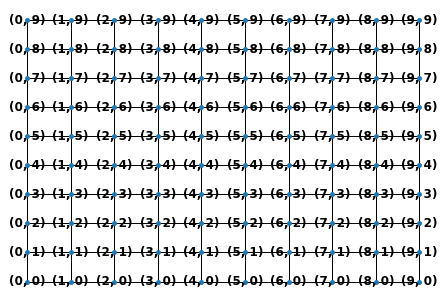

In [4]:
n = 10
t = 4 # tiling for 2D-lattice only
twoD_latt = geometric_network('2D_lattice', size = n, tiling = t, periodic = False)
twoD_latt.display()

 *  ## ring_lattice
     * ### banded = False

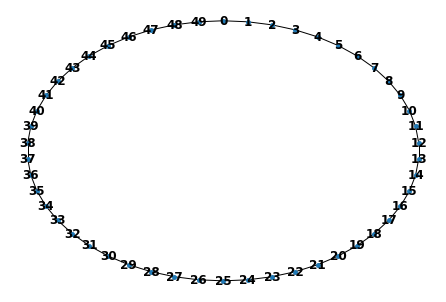

In [5]:
n = 50
ring_latt = geometric_network('ring_lattice', size = n, banded = False)
ring_latt.display()

 *  ## banded_ring_lattice
     * ### banded = True
     * ### band_length = 2

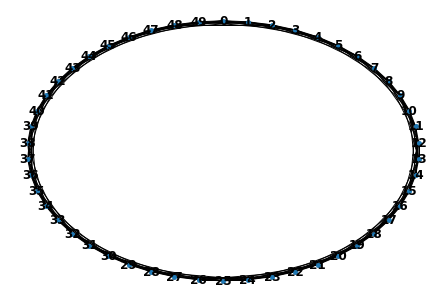

In [6]:
n = 50
banded_ring_latt = geometric_network('ring_lattice', size = n, banded = True, band_length = 4)
banded_ring_latt.display()

 *  ## noisy_ring_lattice
     * ### banded = Bool
     * ### band_length = None
 *  ### noisy_ring_lattice.add_noise_to_geometric()
     * ### noise_type = ER_like
     * ### d2 = int

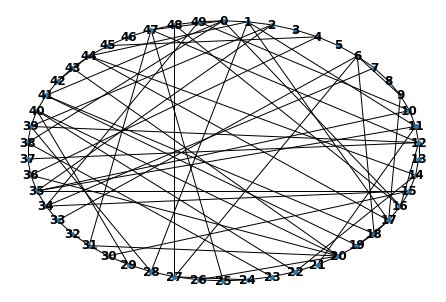

In [7]:
d2 = 2 # nongeometric degree
ring_latt_er_noise = geometric_network('ring_lattice', size = n, banded = False)
ring_latt_er_noise.add_noise_to_geometric('ER_like', d2)
ring_latt_er_noise.display()

 *  ## noisy_ring_lattice
     * ### banded = Bool
     * ### band_length = None
 *  ### noisy_ring_lattice.add_noise_to_geometric()
     * ### noise_type = k_regular
     * ### d2 = int

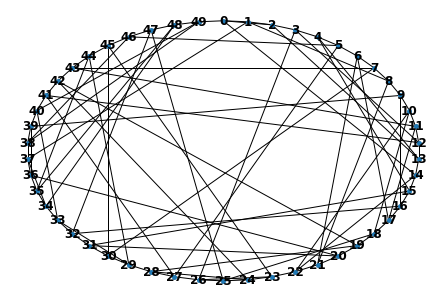

In [8]:
d2 = 2
ring_latt_k_regular =  geometric_network('ring_lattice', size = n, banded = False)
ring_latt_k_regular.add_noise_to_geometric('k_regular', d2)
ring_latt_k_regular.display()

# 2) Sample Excitation Simulation
   ### Use .run_exciation() method for the desired network. Output is the first activation times

In [9]:
p = 0.7 # cascade spreading probablioty
pstart = 0.95 # first spread probability
T = 200 # number of iterations
seed = int(n/2) # node that the spread starts
threshold = 0.1 # resistence of the node to it's neighbors' excitation level
Trials = 2 # number of trials

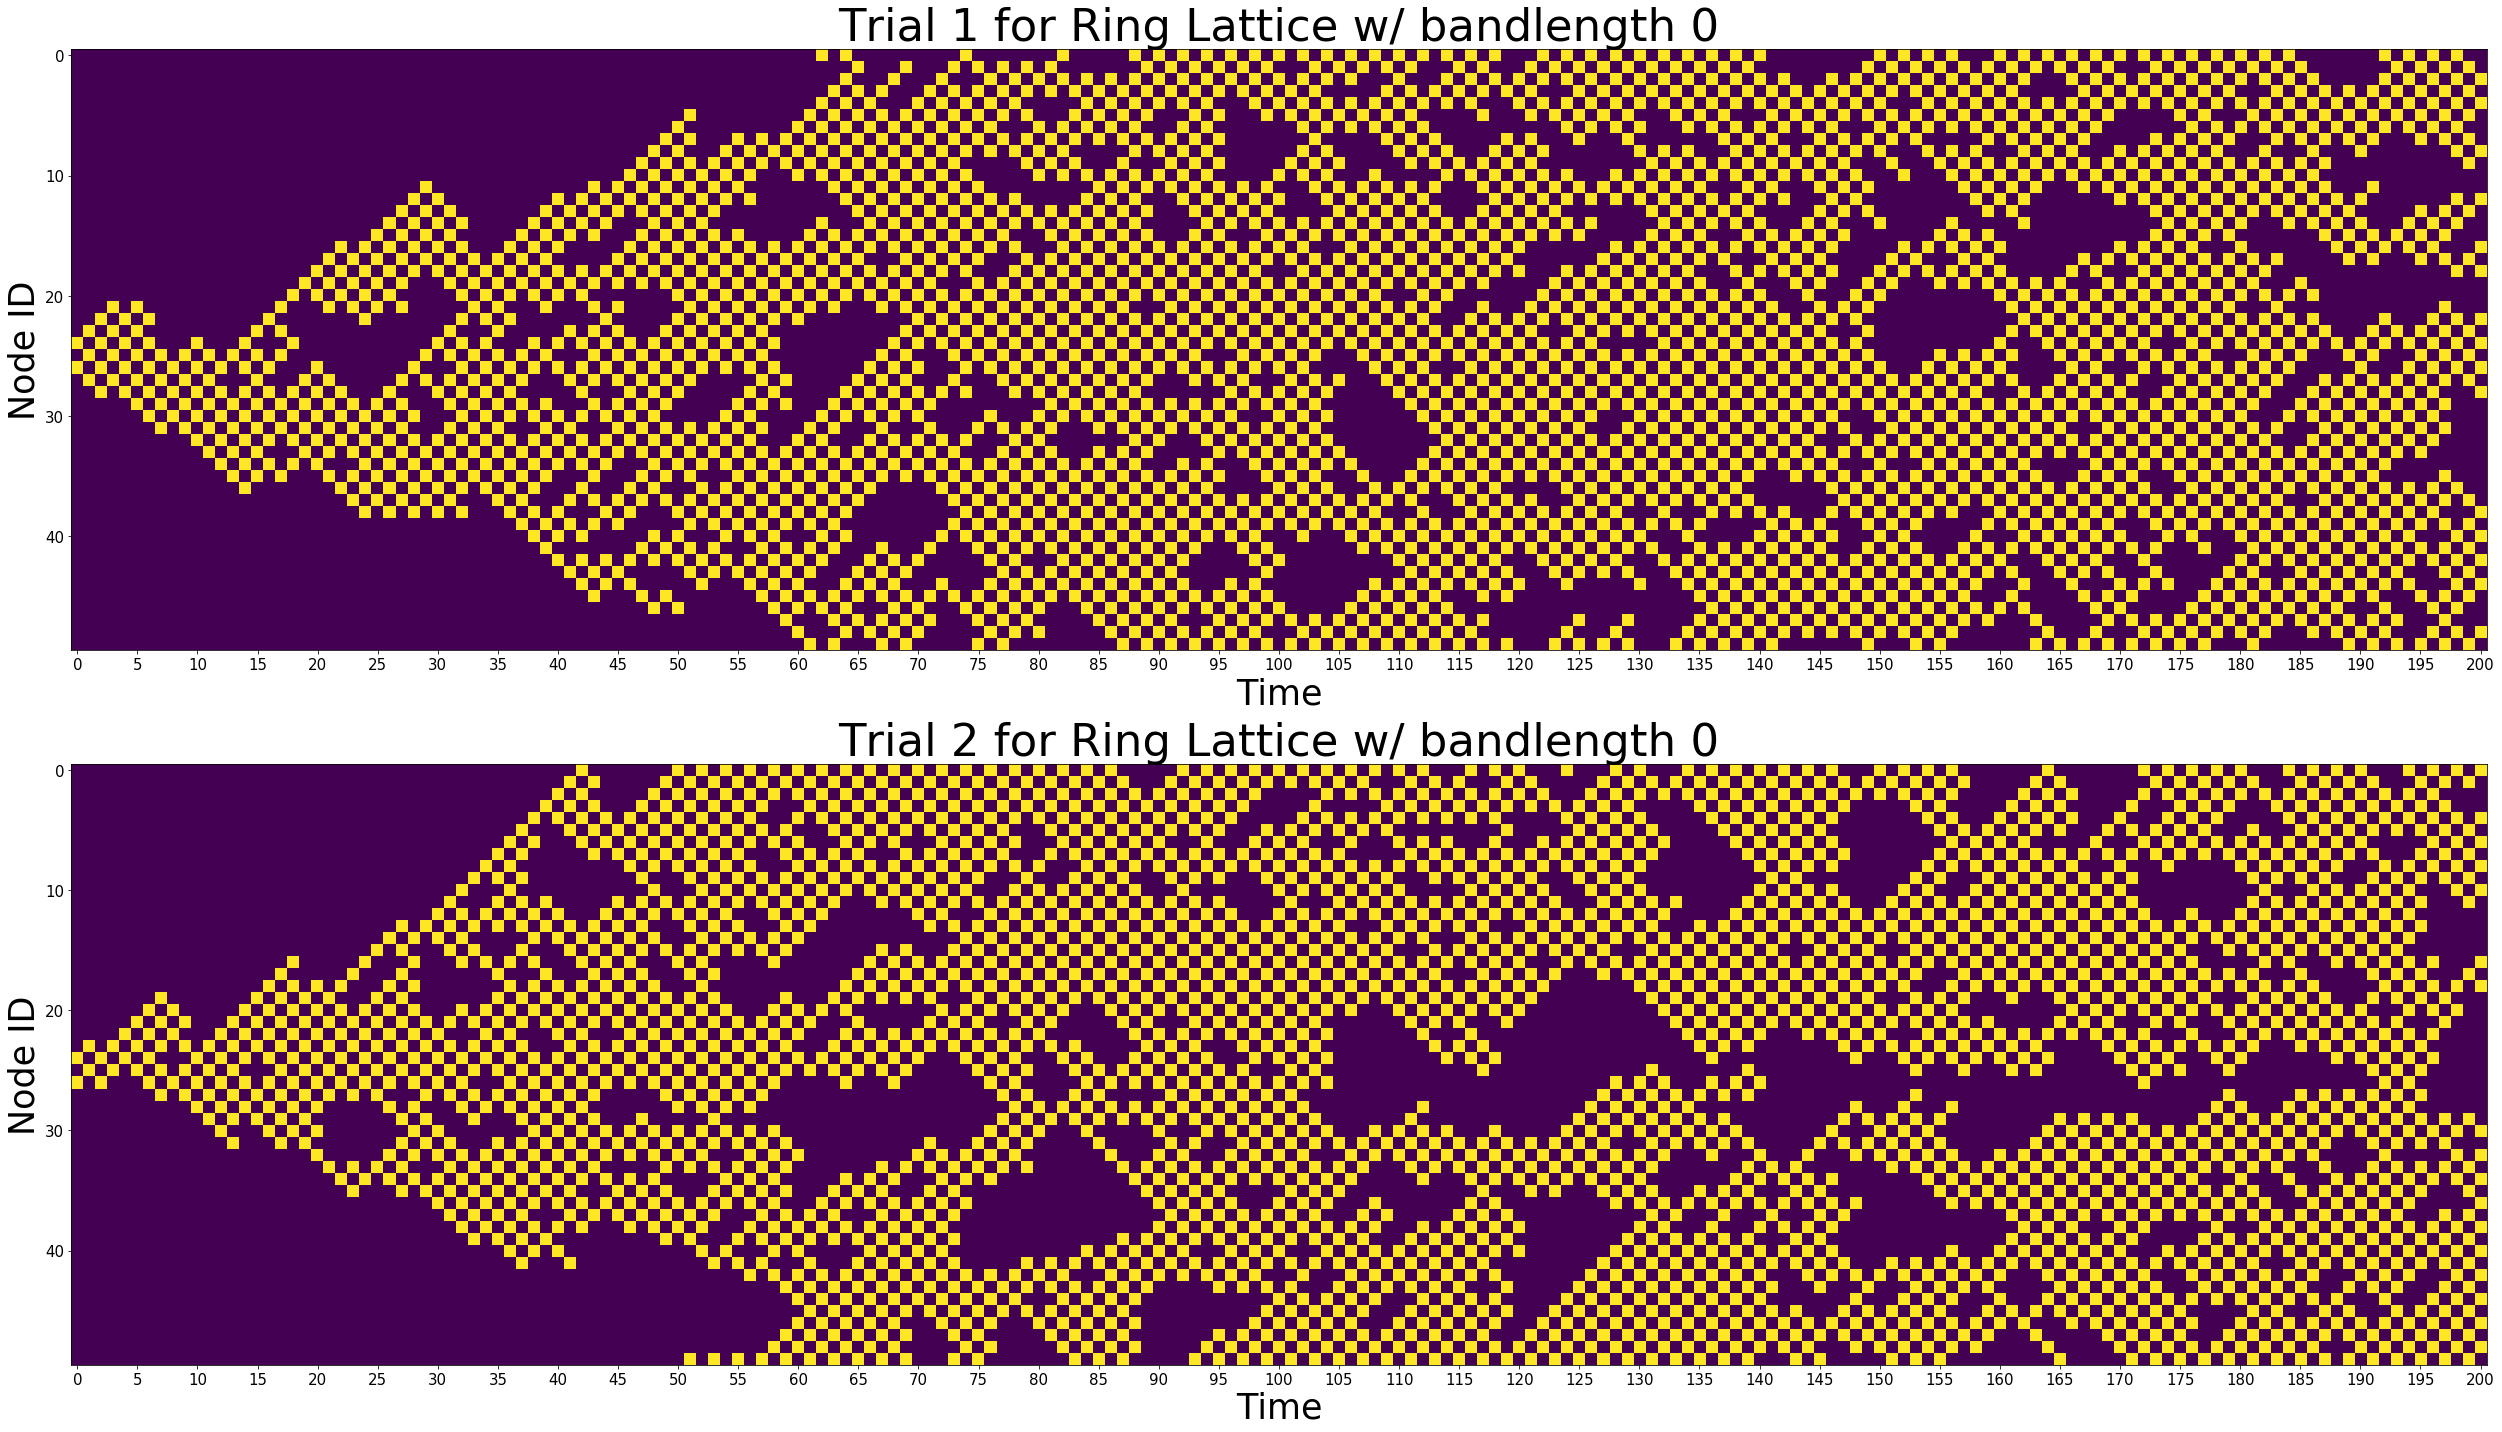

In [11]:
first_excitation_times1 = ring_latt.run_excitation(Trials, p, pstart, T, seed, threshold)

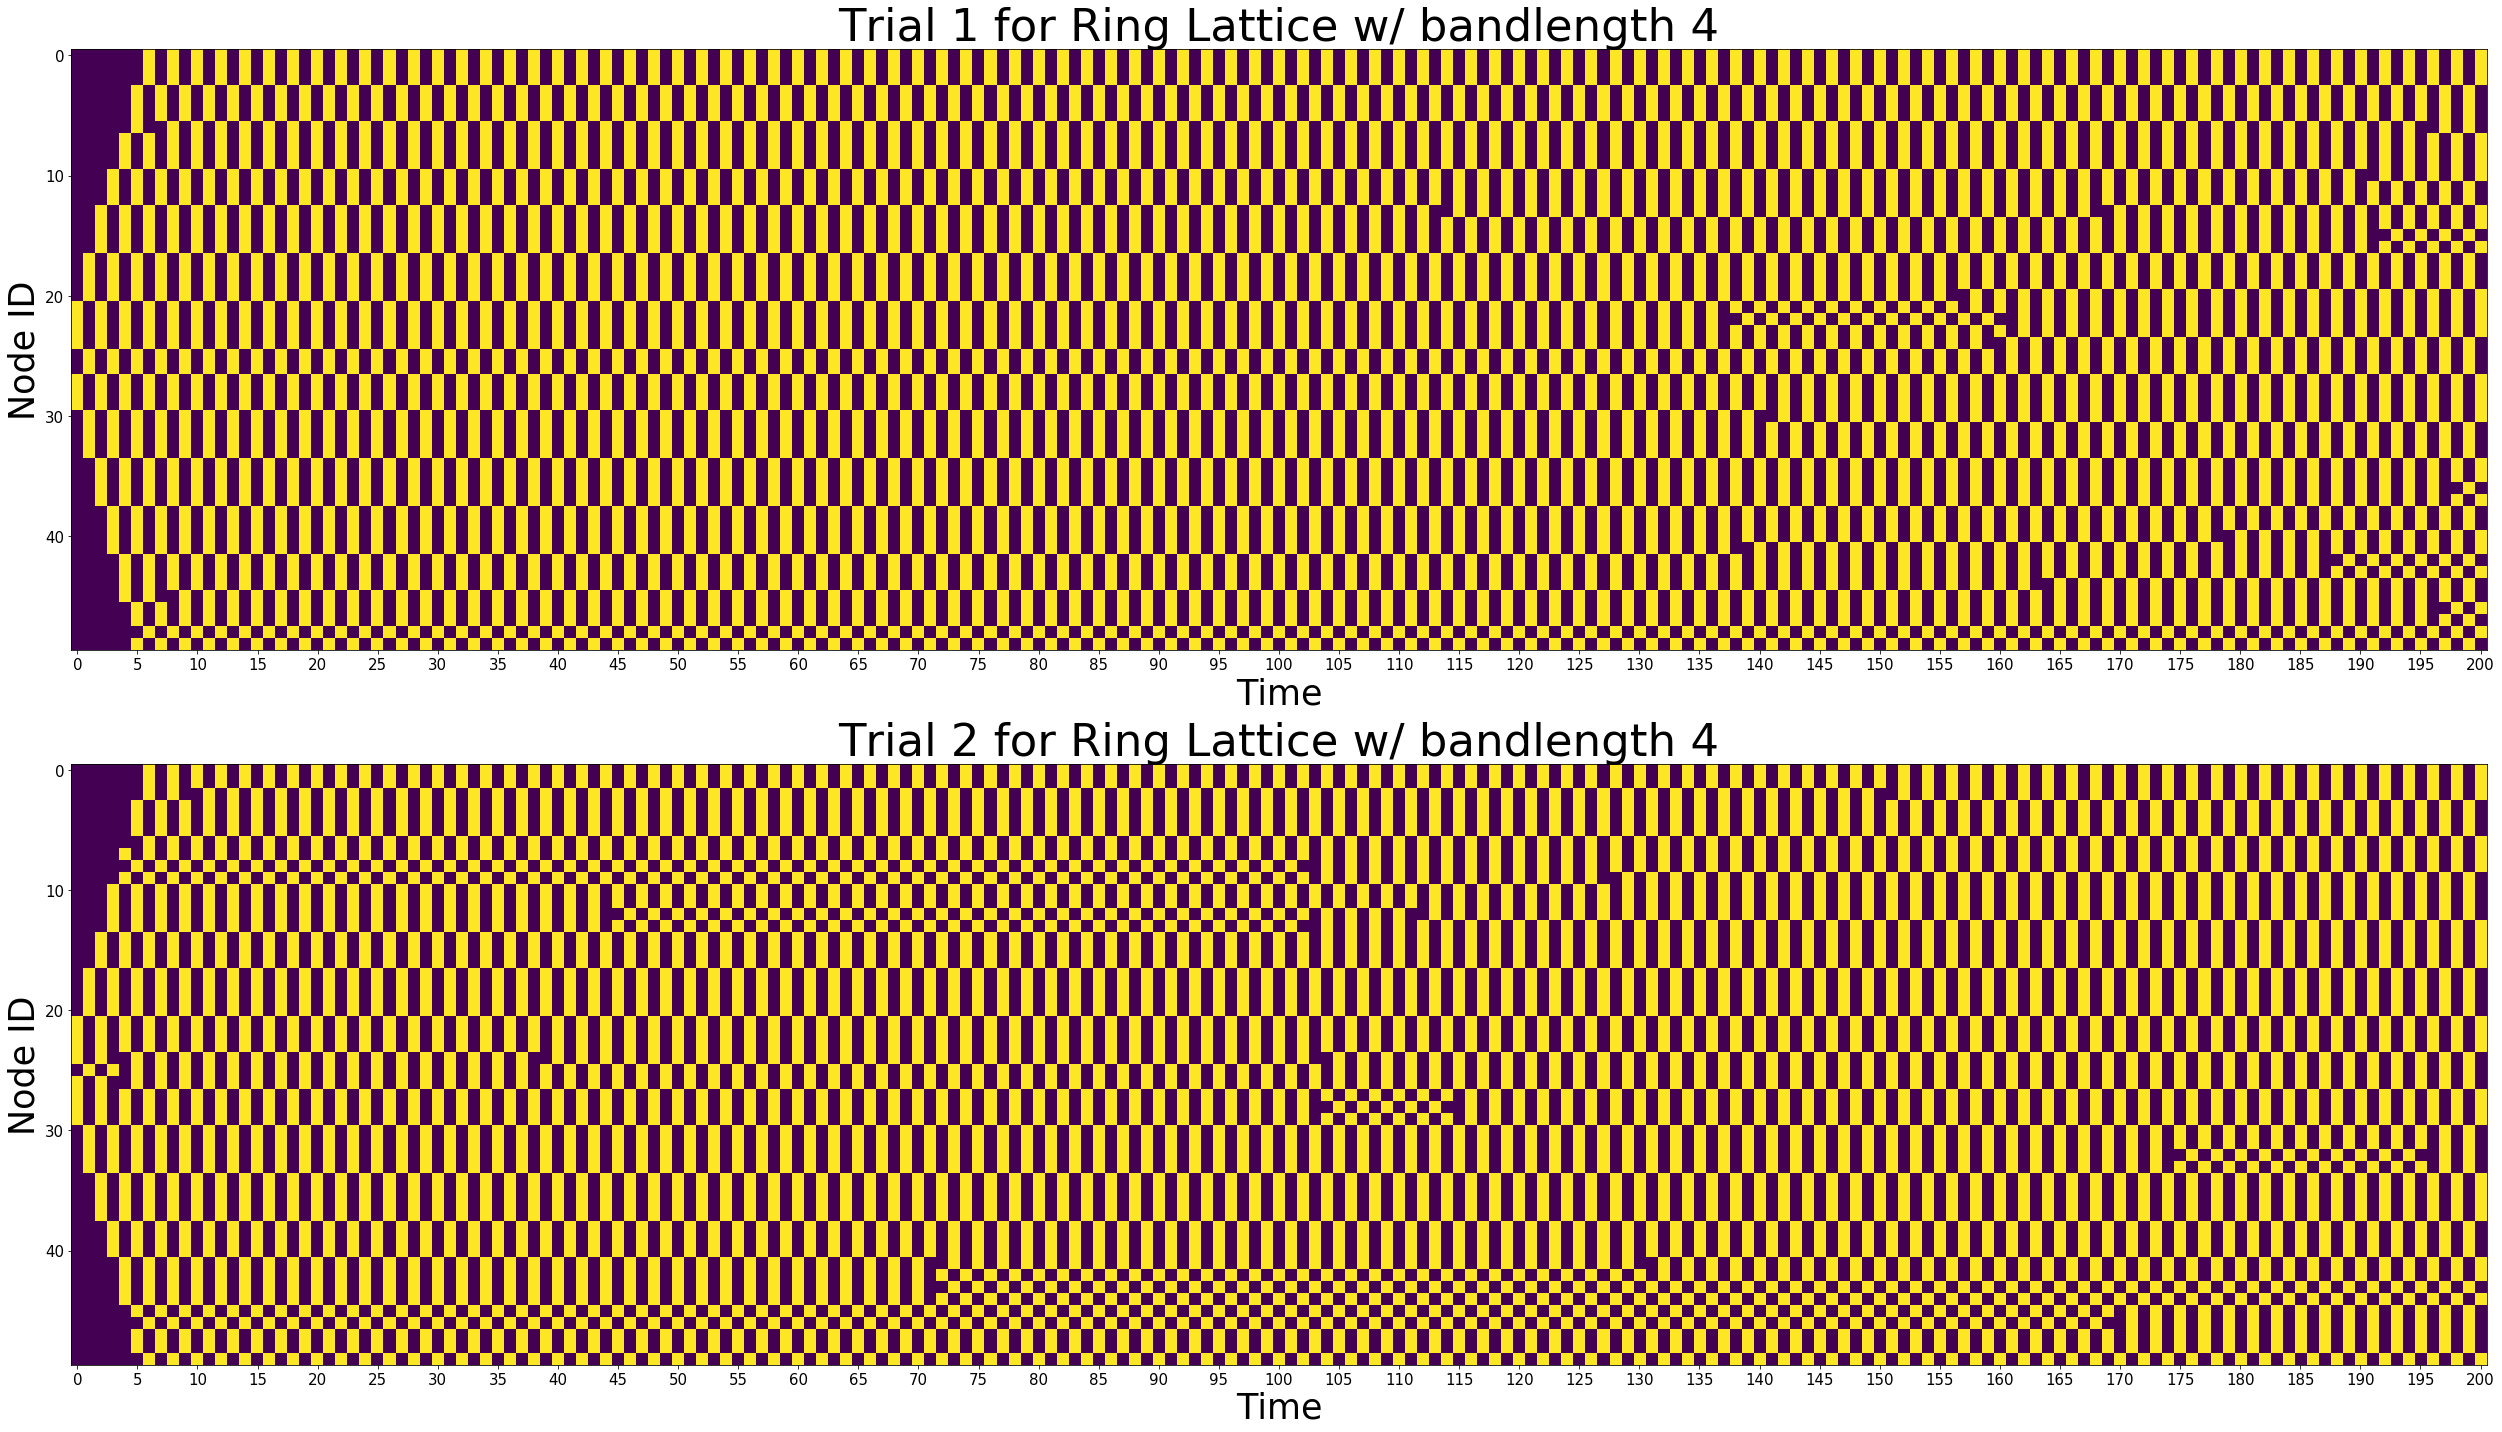

In [12]:
first_excitation_times2 = banded_ring_latt.run_excitation(Trials, p, pstart, T, seed, threshold)

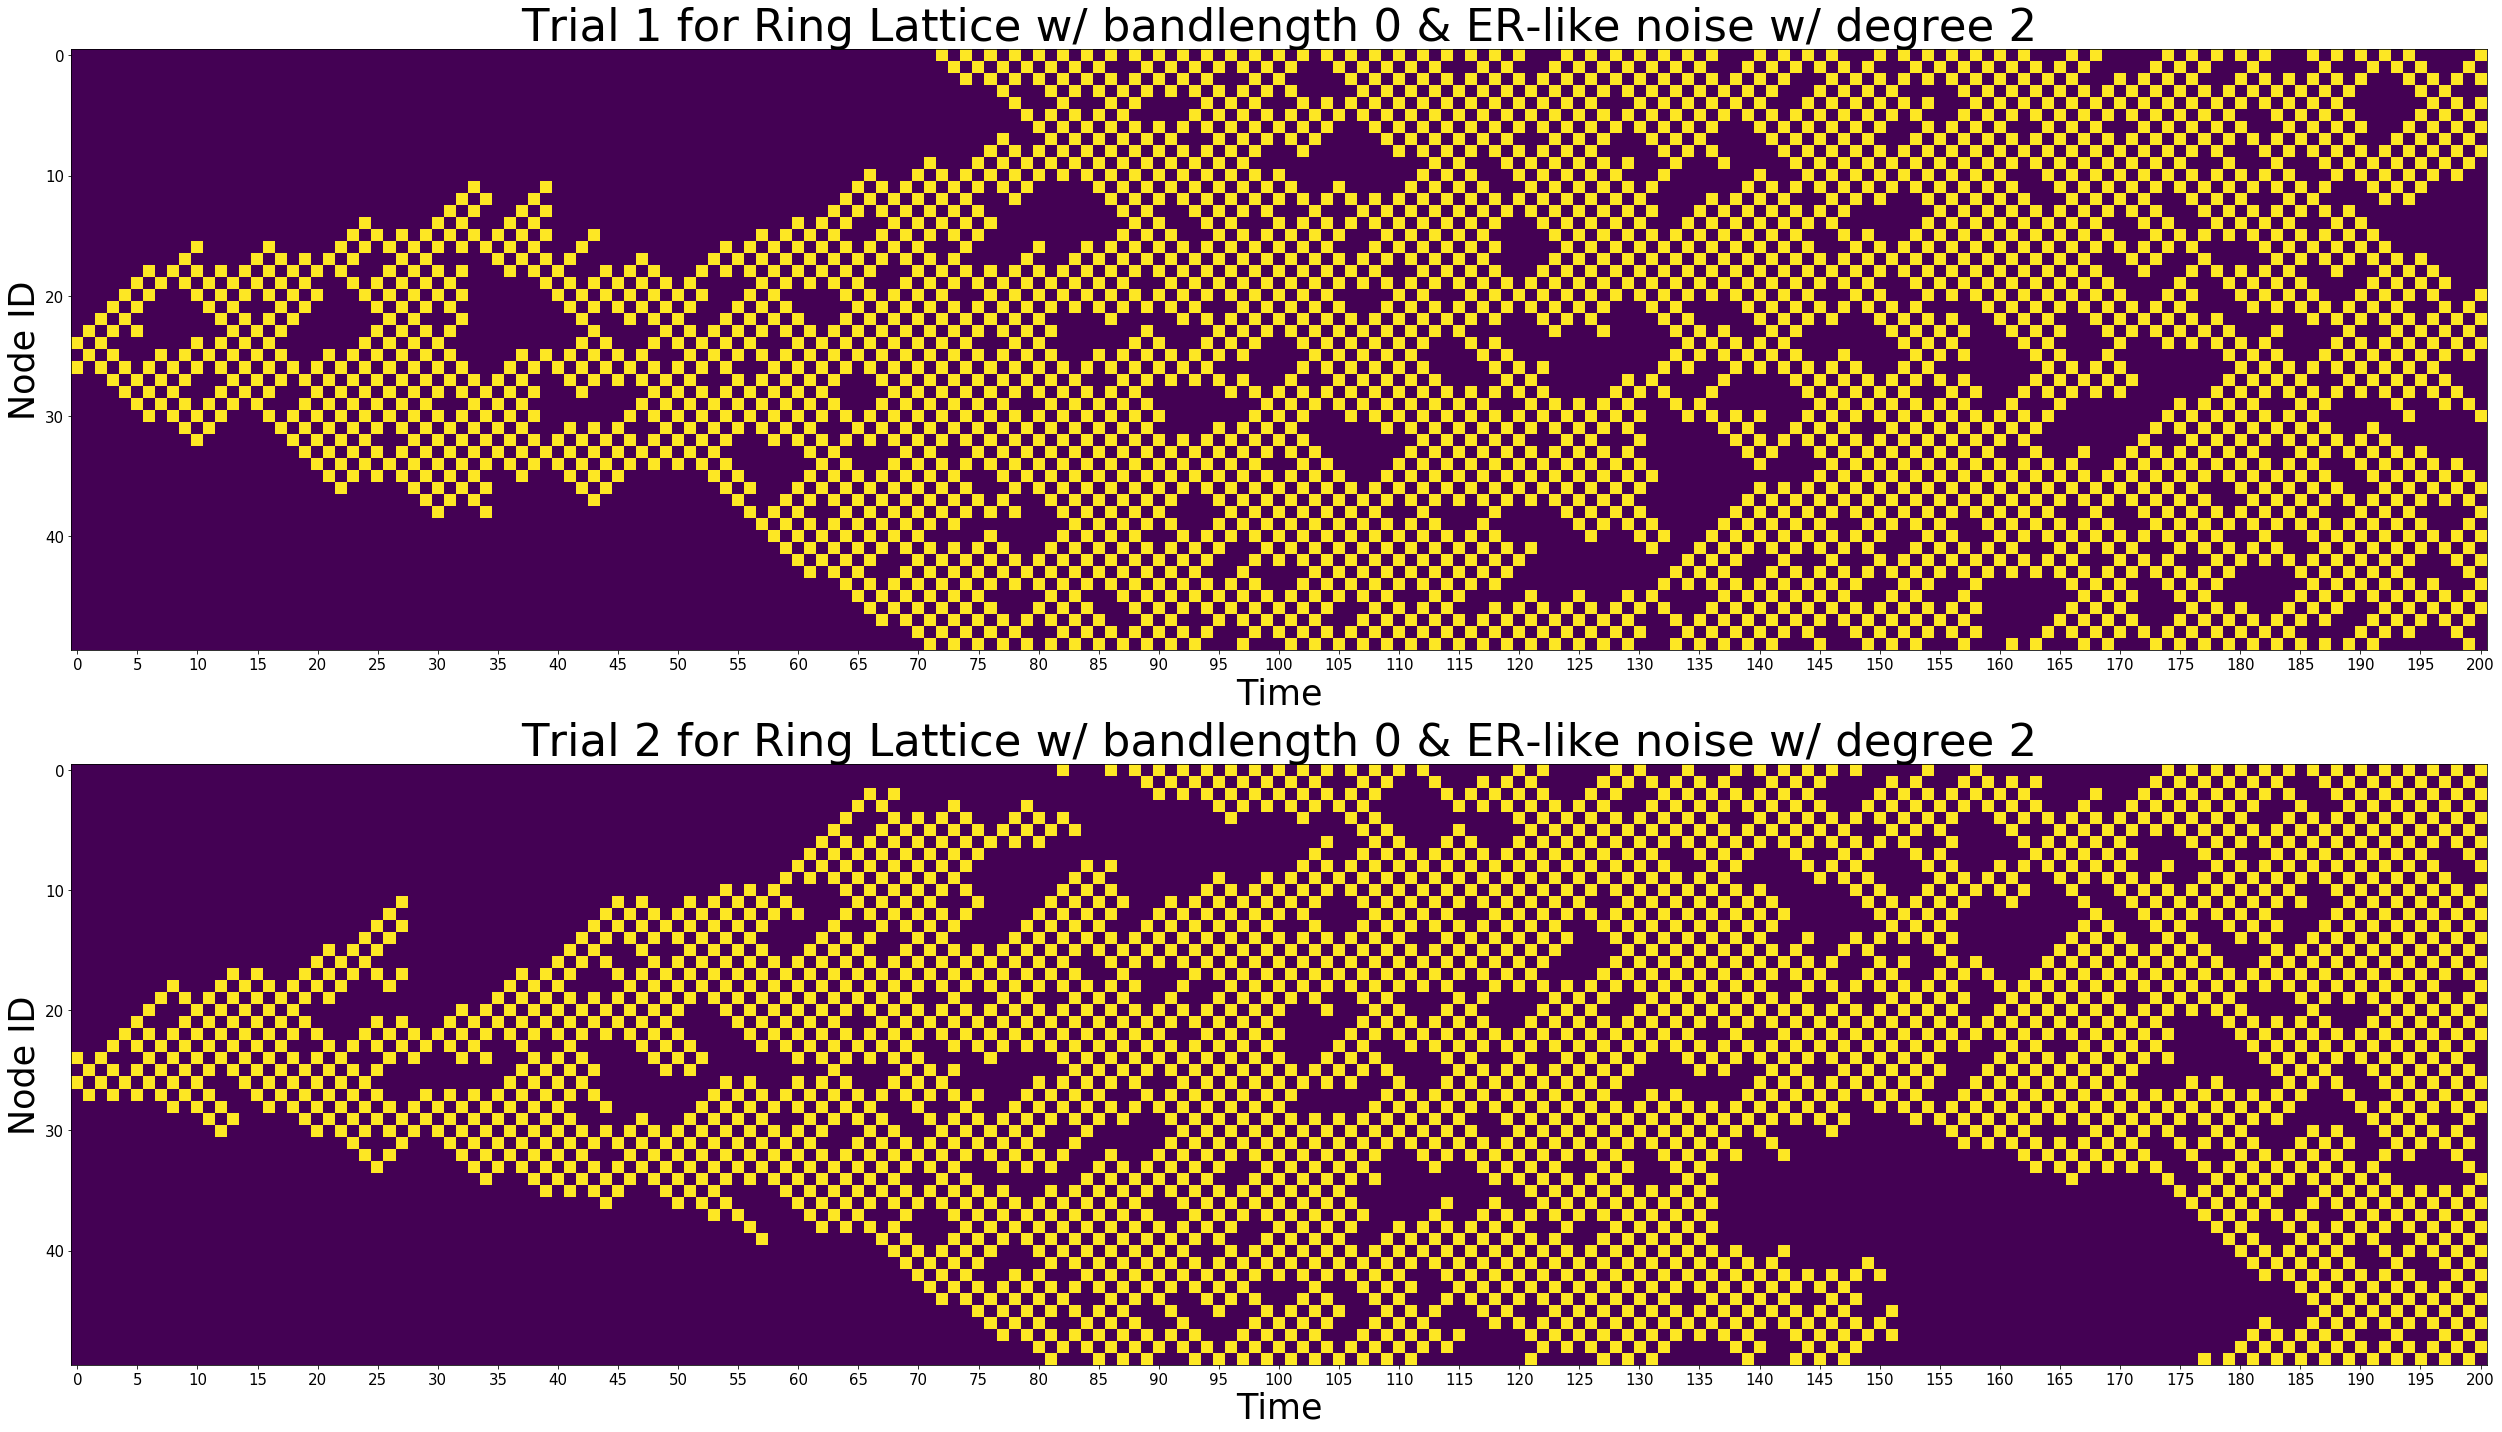

In [13]:
first_excitation_times3 = ring_latt_er_noise.run_excitation(Trials, p, pstart, T, seed, threshold)

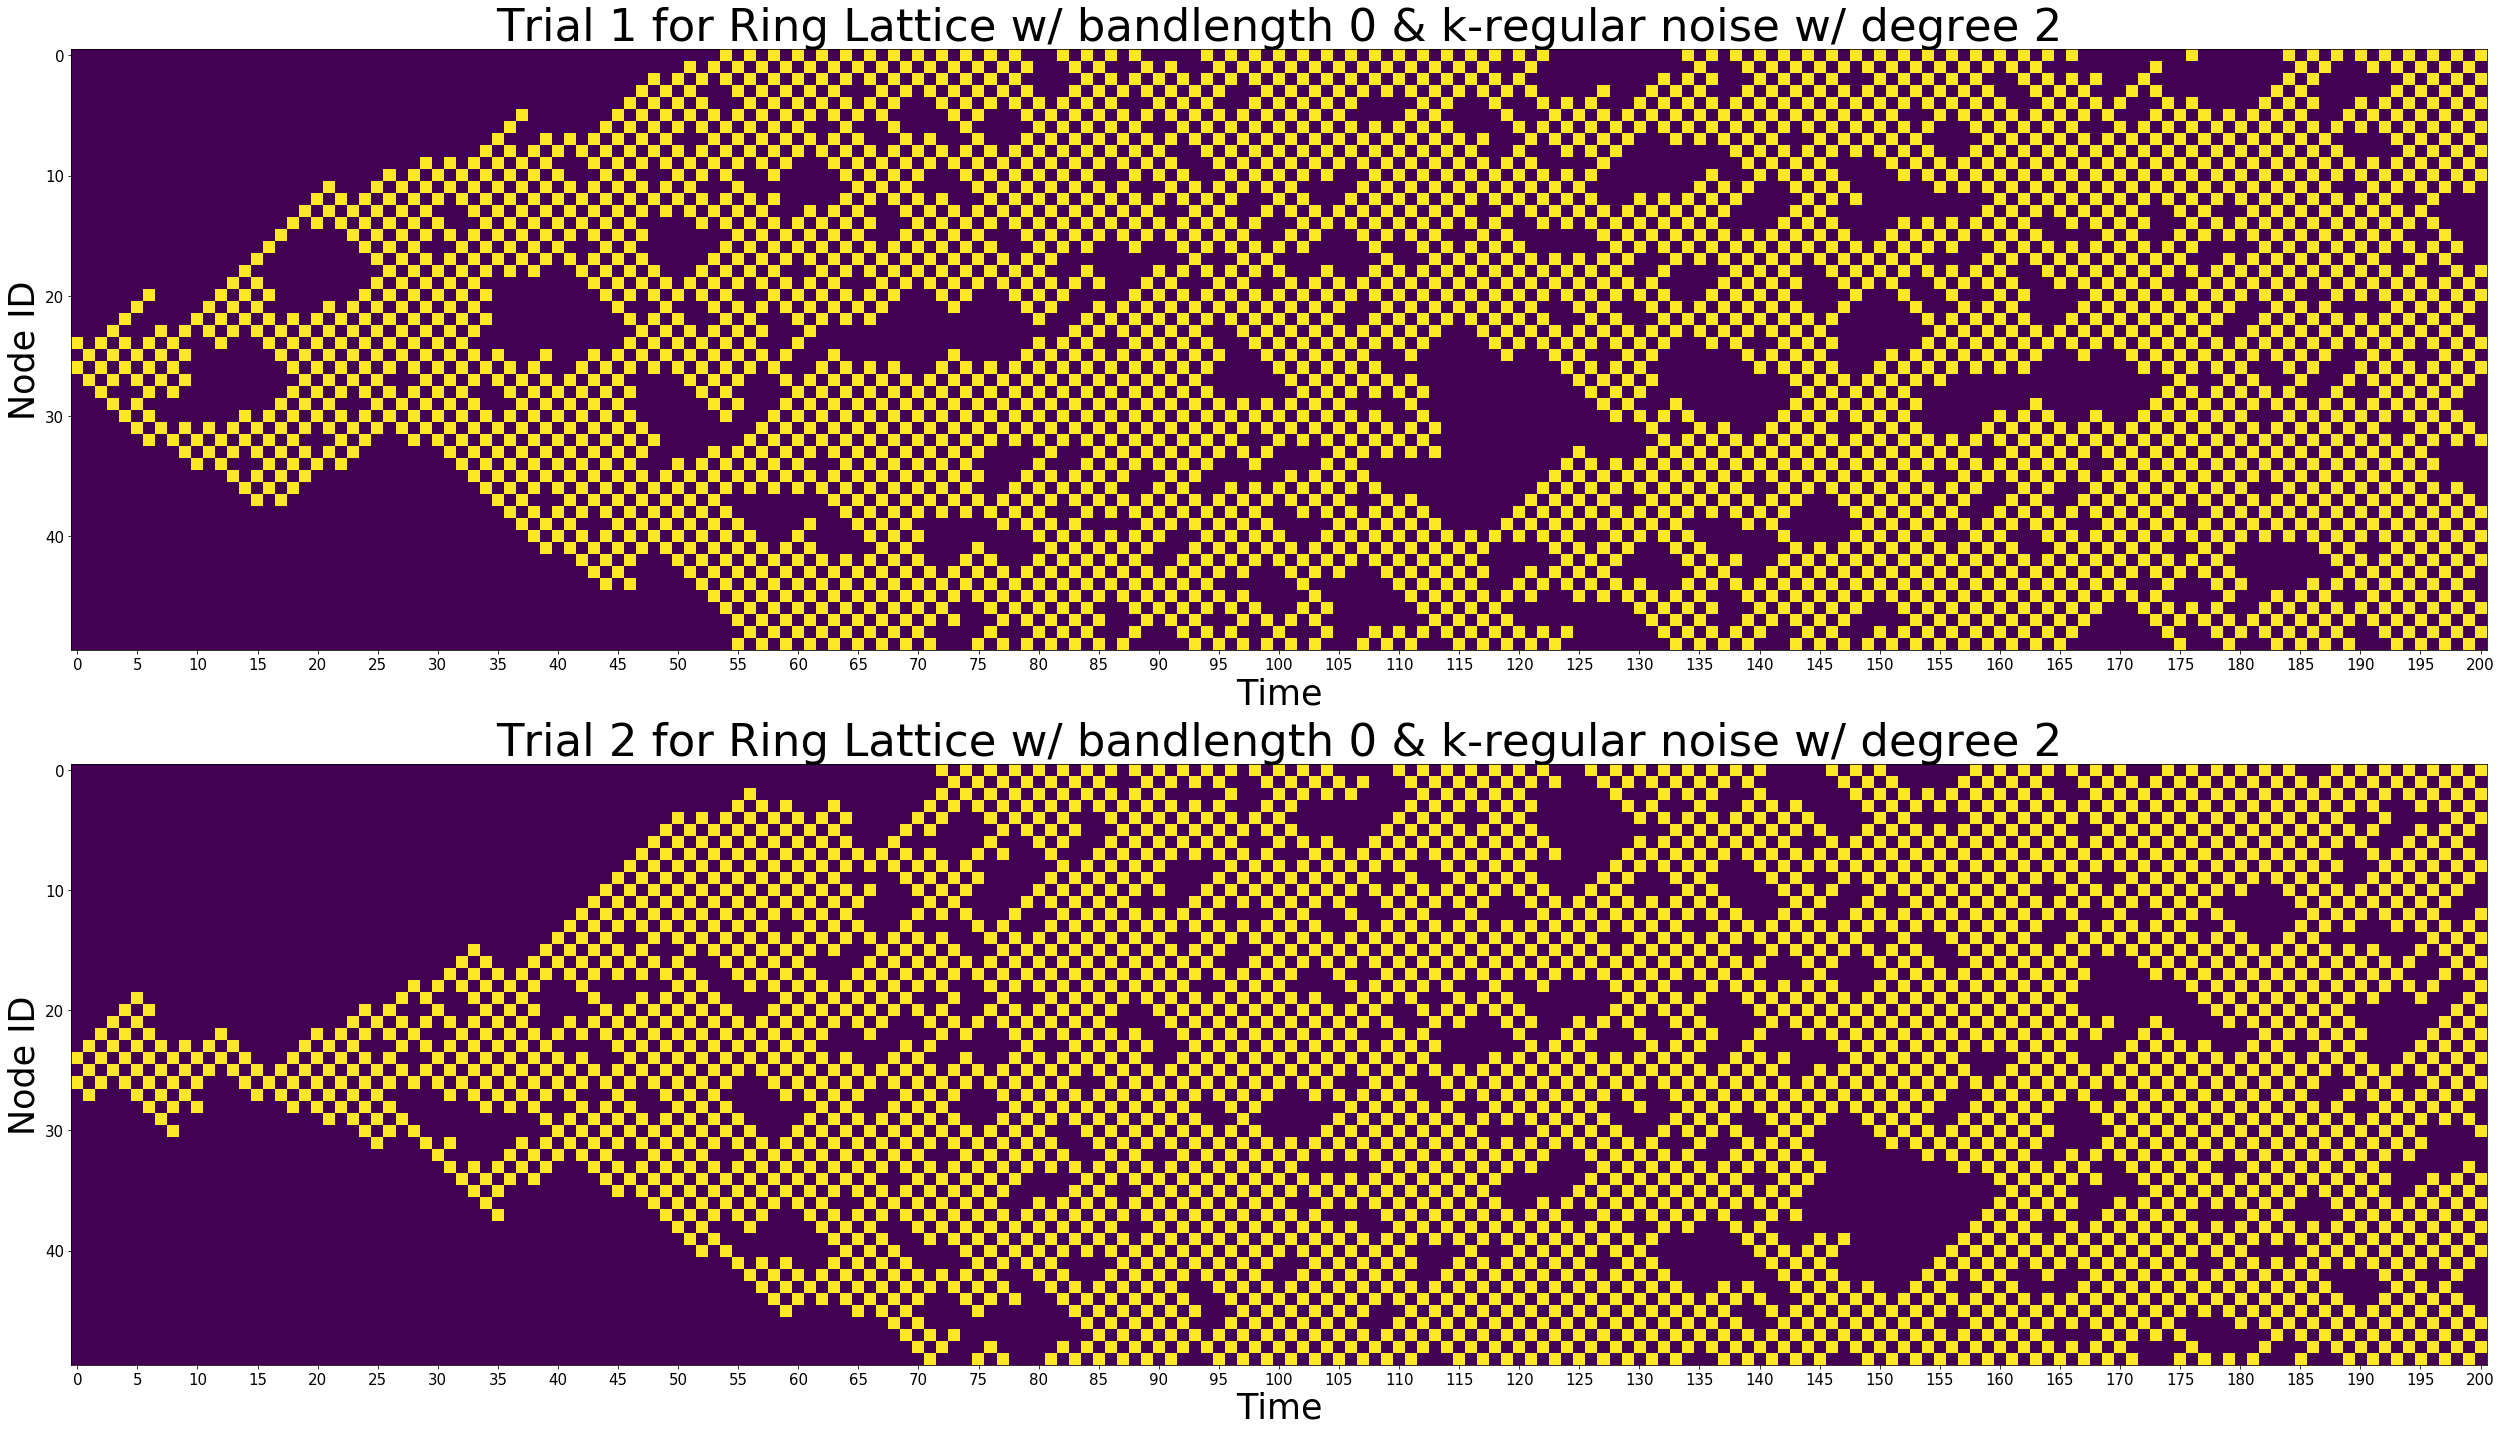

In [14]:
first_excitation_times4 = ring_latt_k_regular.run_excitation(Trials, p, pstart, T, seed, threshold)

# 3) Observing the first activation times
### input the output of the run_excitation to the .spy_first_activation() method

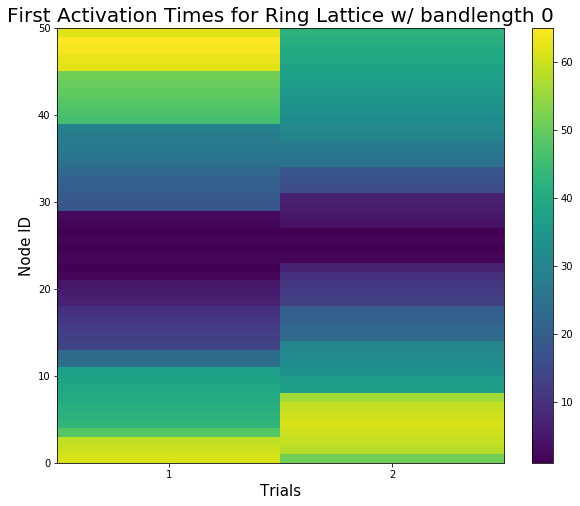

In [15]:
ring_latt.spy_first_activation(first_excitation_times1)

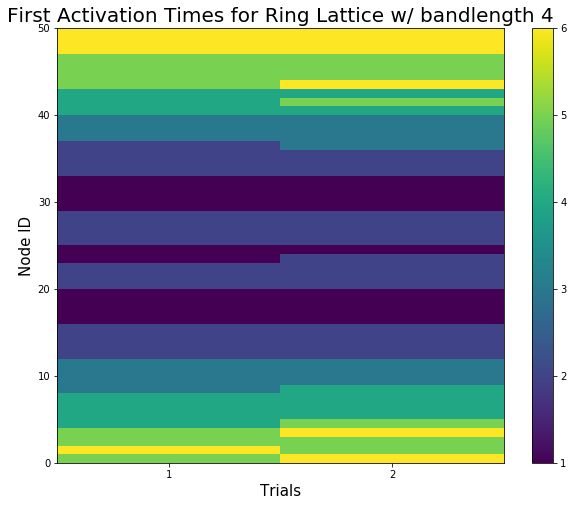

In [16]:
banded_ring_latt.spy_first_activation(first_excitation_times2)

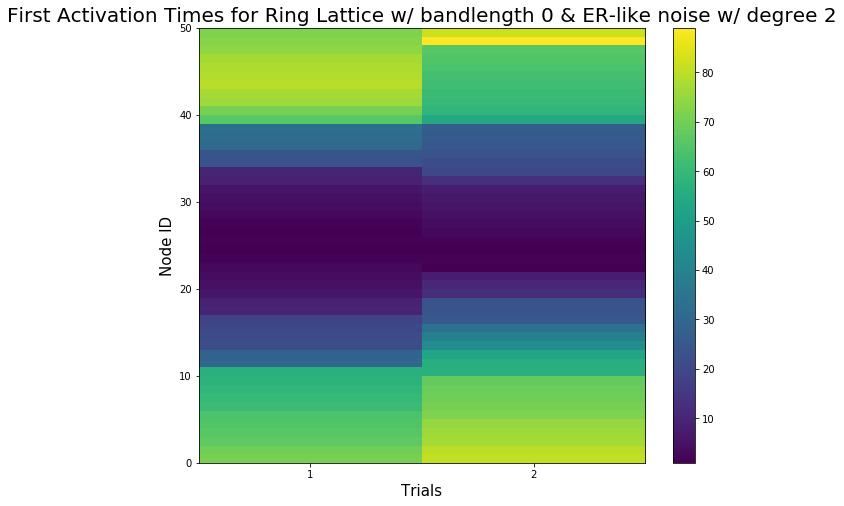

In [17]:
ring_latt_er_noise.spy_first_activation(first_excitation_times3)

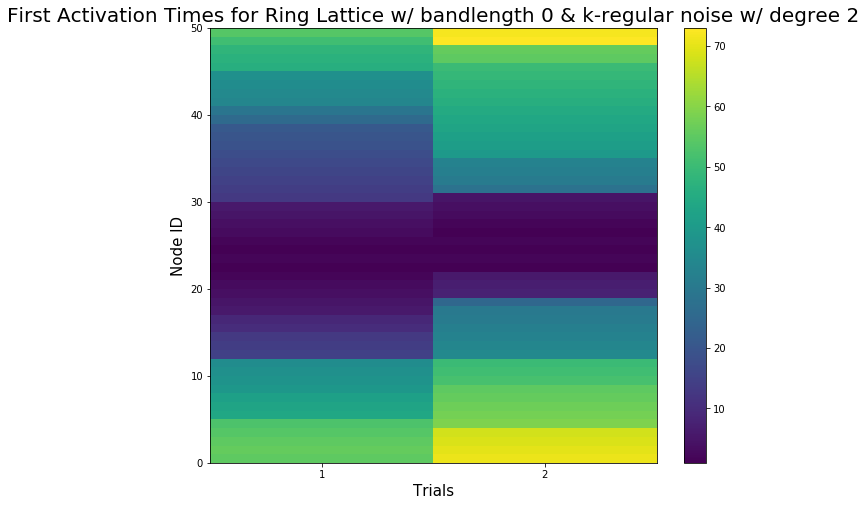

In [18]:
ring_latt_k_regular.spy_first_activation(first_excitation_times4)